___
___
___


# **Datenanalyse & Forecasting Excercise 2024**

___
___
___



# **1. Introduction**

Welcome to our exercise notebook on data analysis and time series forecasting with sktime! This notebook will explore some tools for analyzing data and further show a small pipline approach to forecast future values. This notebook will provide you with some insights and hands-on experience in working with time series data. Therefore, let's get started and dive into the exciting world of data analysis and time series forecasting!

Please note it is mandatory to install all the required software and packages using the guide provided in Ilias before proceeding with this exercise notebook. The guide contains important instructions how to properly set up your environment. This ensures that all the necessary dependencies are installed. Failure to follow the instructions may result in errors or unexpected behavior while working through the notebook.

This is an interactive notebook and also includes some work assignments. Typical tasks are adding lines of code, documenting observations. Work orders are always marked in the color <span style="color:#A00000"> **red** </span>. We suggest you work in pairs or small groups so that you can share observations and discuss the tasks together.


___

## Agenda

1. Introduction, Agenda, learning goals and data loading

2. Data Analysis

3. Forecasting Excercise - Forecasting Pipeline and Steps

___


##  Learning goals (sorted by chapter)

### Learning goals data analysis and time series analysis

    - Enumerate different properties of time series e.g. seasonality    
    - Analyze energy time series and recognize and evaluate seasonal patterns
    - Derive and design appropriate calendrical features by considering seasonality and autocorellation function.


### Learning goals machine learning
    - Name and evaluate various different steps within a machine learning process.
    - Be able to name the advantages of splitting data between training and test data.
     

___



### Colab Setup
Installs all the needed packages in your enviroment.

In [1]:
!pip install pandas;
!pip install statsmodels;
!pip install numpy;
!pip install sktime;
!pip install matplotlib;
!pip install seaborn;
!pip install holidays;

In [2]:
import pandas as pd
data = pd.read_csv('https://data.open-power-system-data.org/household_data/2020-04-15/household_data_15min_singleindex.csv', date_format='%Y-%m-%dT%H:%M:%SZ', index_col = "cet_cest_timestamp", parse_dates=True , sep=',')
data.index = pd.to_datetime(data.index, utc=True)


## Data loading and first preprocessing
As a basis for the data analysis we need data in the first place. This publically available data set is described here: [Full Dataset Introduction](https://data.open-power-system-data.org/household_data/2020-04-15)

Here we have taken only a subset of the data, since we want to deal with only one building. Our choice is the industrial building 3. All the data is scaled in kWh. The building has an installed pv and an energy demand.



In [3]:
import statsmodels.api as sm
from matplotlib import pylab
from pylab import *


# Basic configuration to get beautiful pictures
pylab.rcParams['figure.figsize'] = (16, 9)

# Get the relevant data for this excercise and resample it to hourly resolution to save runtime complexity
data["demand"] = data["DE_KN_industrial3_grid_import"].diff(1).resample("1h").mean()
data["solar"] = (data["DE_KN_industrial3_pv_facade"].diff(1) + data["DE_KN_industrial3_pv_roof"].diff(1)).resample("1h").mean()

# Omit data without values
data = data[["demand","solar"]].dropna()
# Let the data start with a full day and end with a full day
data =  data[(data.index >= pd.to_datetime("2016-11-03",utc=True)) &  (data.index < pd.to_datetime("2017-06-04",utc=True))]
data = data.asfreq('1h')

# **2. Data Analysis**

<img src="https://imgs.xkcd.com/comics/data_trap.png" width="400" height="400">

[This xkcd comic you can find here](https://xkcd.com/2582/)

Within the data analysis chapter, we will first use simple tools from Pandas to get an overview of the data set.
After that, we will make a daily observation of the load and analyse the difference between a weekday and weekend.
In the last part we will use more complex tools like autocorellation plots and a seasonal decomposition to identify properties like trend and seasonality in our time series.

First of all, we would like to show you three very simple functions that Pandas has ready for you :

## Warmup and get familiar with the data

1. head() First five rows of the data set. Commonly used as a sanity check to see how the Data is constructed. [API](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html)
2. describe() Provides basic satistical values of the dataset. For example, mean, standard deviation and quantiles.[API](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html)
3. plot() The plot function draws a simple plot over all collumns of the given dataset with mathplolib. [API](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

### <span style="color:#A00000"> Use the three functions (head, describe and plot) below! </span>



In [4]:
# Use the head function

data.head()

,demand,solar
cet_cest_timestamp,,
2016-11-03 00:00:00+00:00,15.0000,0.0
2016-11-03 01:00:00+00:00,15.1875,0.0
2016-11-03 02:00:00+00:00,15.0000,0.0
2016-11-03 03:00:00+00:00,14.8125,0.0
2016-11-03 04:00:00+00:00,14.4375,0.0


In [5]:
# Use the describe function
data.describe()

,demand,solar
count,5112.000000,5112.000000
mean,19.426448,0.421909
std,8.721126,0.865757
min,7.187500,0.000000
25%,14.187500,0.000000
50%,14.875000,0.000000
75%,23.562500,0.337813
max,50.187500,4.289000


 ### <span style="color:#A00000 "> Discuss in your group: </span>
 - <span style="color:#A00000 "> Based on these broad statistic, what would you infer about the house considered? </span>
 - <span style="color:#A00000 "> Do these statistics help you to get a feel for the data and what it looks like? </span>
 - <span style="color:#A00000 "> Does this data seem realistic? </span>
 - <span style="color:#A00000 "> Do you see any challanges? </span>
 - <span style="color:#A00000 "> How much data do we have? </span>

< Space for your answers>


<Axes: xlabel='cet_cest_timestamp'>

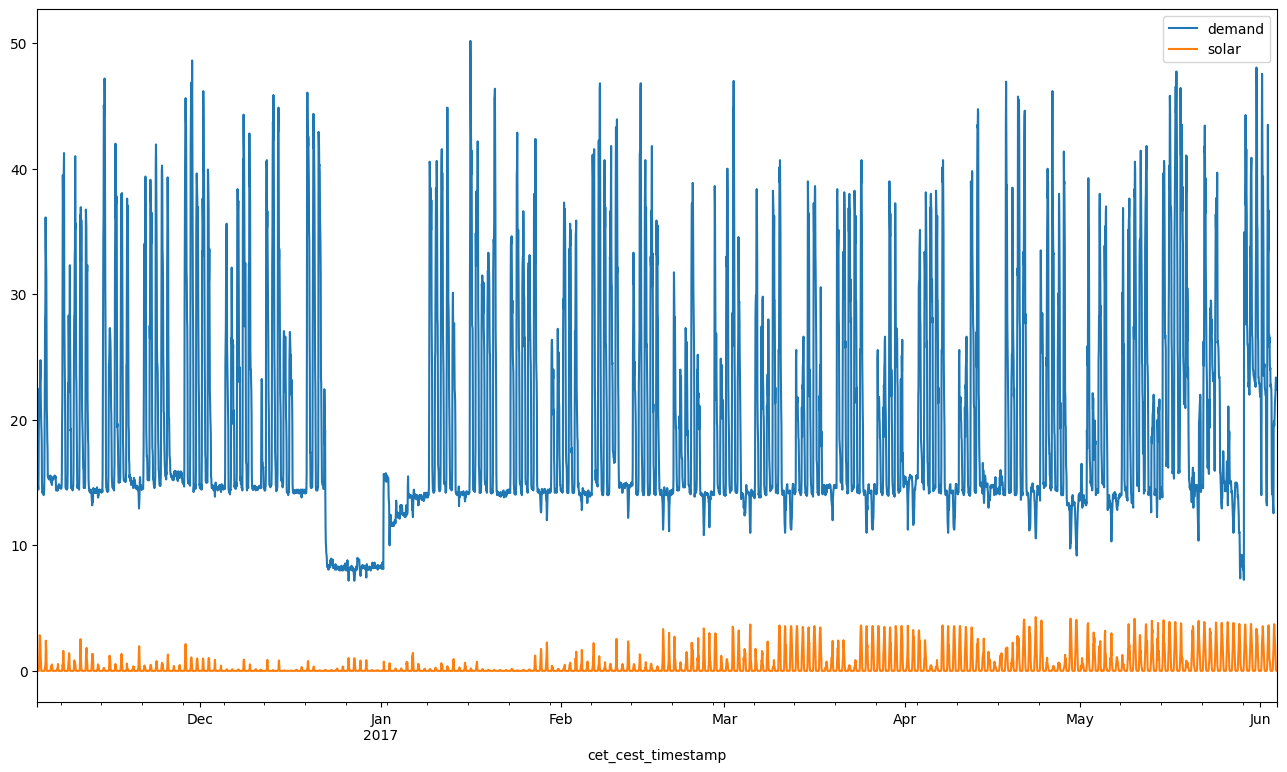

In [6]:
# Use the plot function
data.plot()

 ### <span style="color:#A00000 "> Point out two observations about the given data! </span>

1. < Observation 1 >
2. < Observation 2 >

 ### <span style="color:#A00000 "> Discuss in your group: </span>
 - <span style="color:#A00000 "> What did you find more beneficial, the statistics of the plots? </span>
 - <span style="color:#A00000 "> Do you see a benefit in both statstics and plots or would you only consider one of them? </span>

< Space for your answers>


## Daily observations

This part first shows an example of the pivot table how it is used to plot the data on daily basis. Further it extends by using the month attribute to plot the months in different plots. As you can see differnt days of the month are plotted.

In [7]:
# Calculating the hour of the day the weekday and the day since the beginning of the time series to create the pivot table
data["hour"] = data.index.hour.values
data["weekday"] = data.index.weekday.values
data["month"] = data.index.month.values
data["days_since_start"] = [int(x/(24)) for x in range(0,len(data))]

# creates the pivot table to get a table with the days since start in the columns and hours of the day as rows. For later usage the months are taken into account as the value parameter.
pivot_solar = pd.pivot_table(data, index=['hour'],columns=['days_since_start'], values=['solar','month'])
pivot_solar["solar"]


days_since_start,0,1,2,3,4,5,6,7,8,9,...,203,204,205,206,207,208,209,210,211,212
hour,,,,,,,,,,,,,,,,,,,,,
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00600,0.00600,0.00775,0.00800,0.00775,0.00675,0.00400,0.00000,0.00775,0.00975
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.11050,0.12875,0.12900,0.14325,0.13475,0.14750,0.06150,0.02250,0.09000,0.14775
5,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.51375,0.67775,0.67675,0.65250,0.64175,0.63600,0.44925,0.21150,0.34375,0.67950
6,0.05275,0.01375,0.00500,0.00575,0.00975,0.03800,0.03100,0.00775,0.00400,0.00775,...,1.18200,1.28150,1.27250,1.24500,1.20650,1.28675,0.95100,0.71725,1.03475,1.26375
7,0.40000,0.15425,0.12800,0.02250,0.26825,0.36725,0.29800,0.19400,0.17500,0.14375,...,1.90725,1.83875,1.81000,1.78775,1.74225,1.82050,1.69125,1.38125,1.75875,1.76475
8,1.28225,0.38100,0.36250,0.10150,0.48200,0.62200,0.79300,0.93575,0.71200,0.44725,...,2.60650,2.64325,2.61575,2.53225,2.48050,2.52000,2.29025,2.37750,2.56975,2.53550


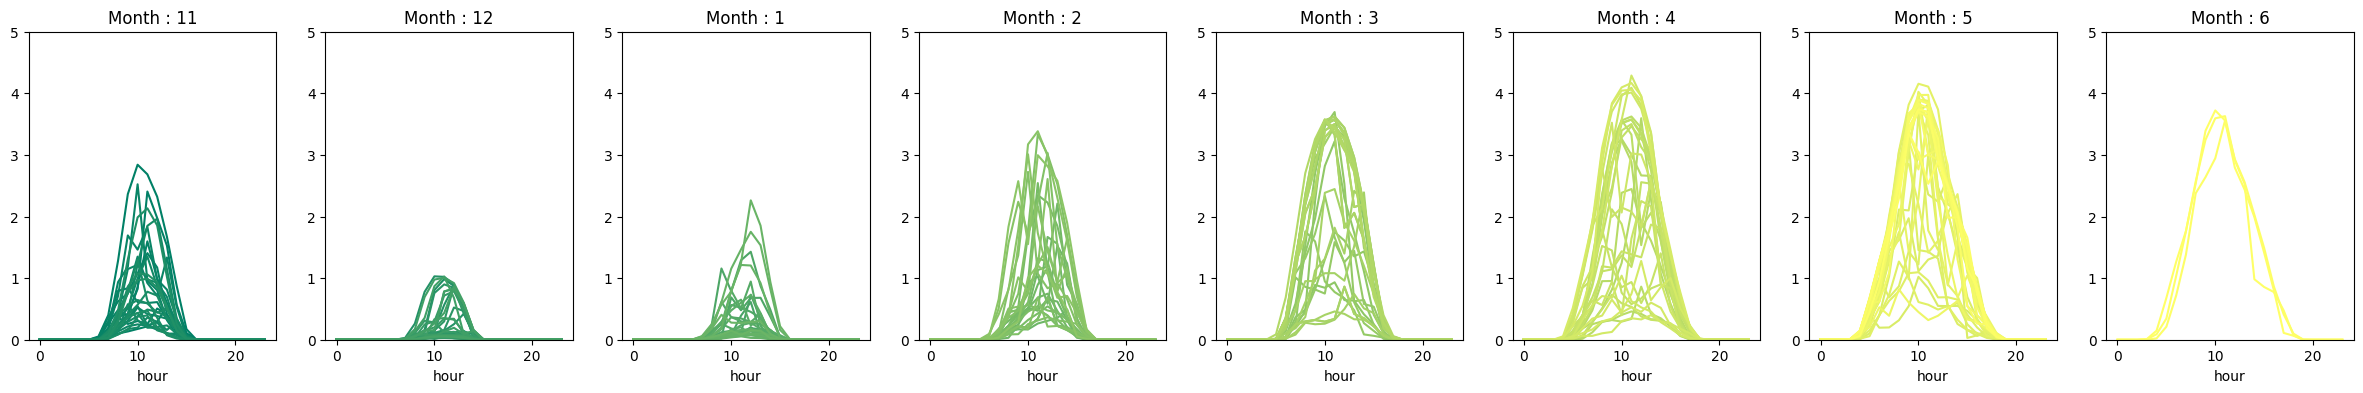

In [8]:
fig, ax = plt.subplots(1,len(data["month"].unique()))
for i in range(len(data["month"].unique())):
    pivot_solar[pivot_solar["month"]==data["month"].unique()[i]]["solar"].plot(ax=ax[i],figsize=(30, 4), layout= (7,1),ylim = (0,5),legend=False, colormap="summer", title="Month : " + str(data["month"].unique()[i]))

 ### <span style="color:#A00000 "> Discuss in your group: </span>
 - <span style="color:#A00000 "> What do you observe during the different months ? </span>

### Workingdays

 ### <span style="color:#A00000 "> Plot only the working days (i.e. Monday-Friday):</span>
 - <span style="color:#A00000 ">The aim is to first filter the data to only get the days from Monday to Friday.</span>
 - <span style="color:#A00000 ">Create a variable ``working_day_data`` and use the weekday column in ``data`` to select the working days. The weekday column is enumerated from 0-6 with 0 being monday and 6 sunday. Therefore working days are the days with a weekday value smaller than five. You can select a column in pandas with ``data["column_name"]`` and if you want to select a subset of the data based on the value in this column you need to use the syntax ``data[data["column_name"] * x]``, where ``*`` indicates a mathematical operater such as ``<`` and ``x`` is the condition. For example, to only select Tuesday you would use ``tuesday_data = data[data["weekday"] == 1]``.</span>
 - <span style="color:#A00000 ">Create the pivot table similar to the example above using the function pivot_table from pandas! [API](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html). Make sure you use the filtered ``working_day_data`` variable created above.</span>
 - <span style="color:#A00000 ">Extend the pivot table to plot working days. Use "days_since_start" as ``columms``, "hour" as ``index`` and "demand" as ``values``!</span>

<Axes: xlabel='hour'>

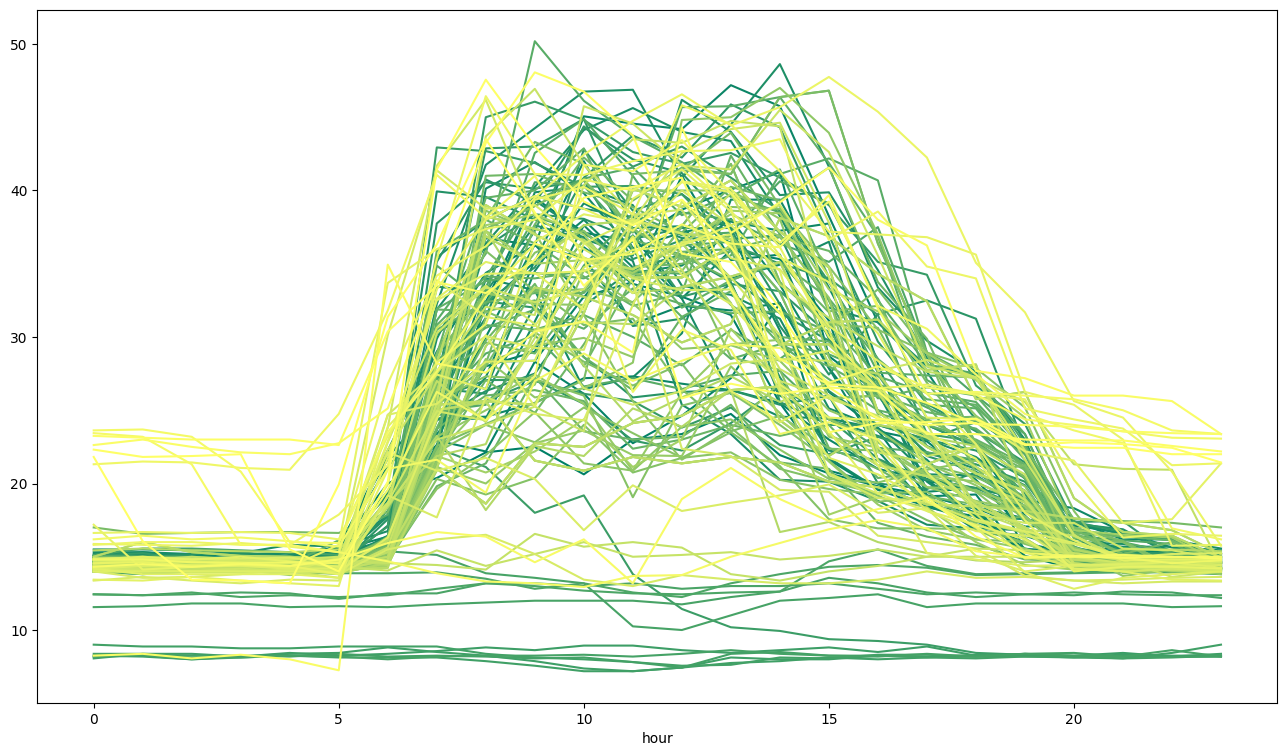

In [9]:

# this get's gapped
working_day_data = data[data["weekday"] < 5]
pivot_workingdays = pd.pivot_table(working_day_data, index=['hour'],columns=['days_since_start'], values=['demand'])

# plots the data
pivot_workingdays["demand"].plot(legend=False,colormap="summer")



### Weekend

 ### <span style="color:#A00000 "> Plot the weekends:</span>
 - <span style="color:#A00000 ">Repeat the task above, but this time only select the weekends (remember weekday is enumerated from 0-6, with 0 being Monday).</span>

<Axes: xlabel='hour'>

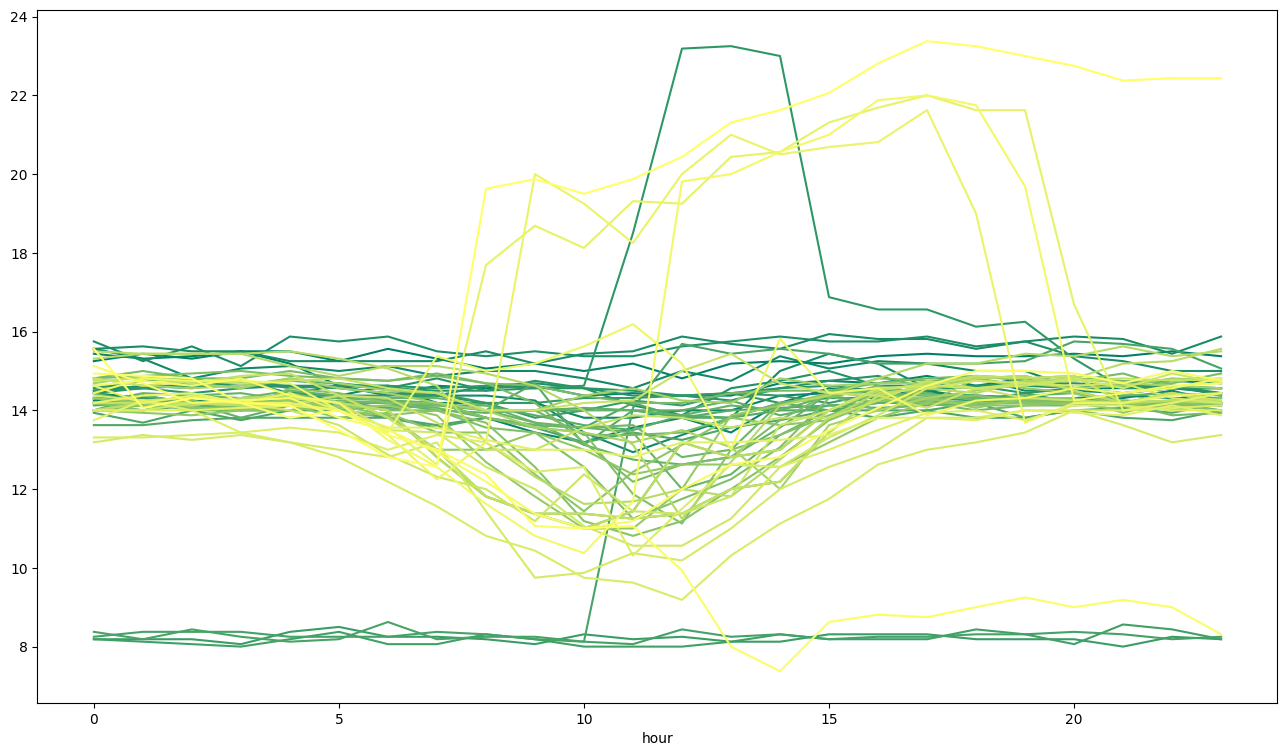

In [10]:

# this get's gapped
weekday_data = data[data["weekday"] >= 5]
pivot_weekends = pd.pivot_table(weekday_data, index=['hour'],columns=['days_since_start'], values=['demand'])
pivot_weekends["demand"].plot(legend=False,colormap="summer")


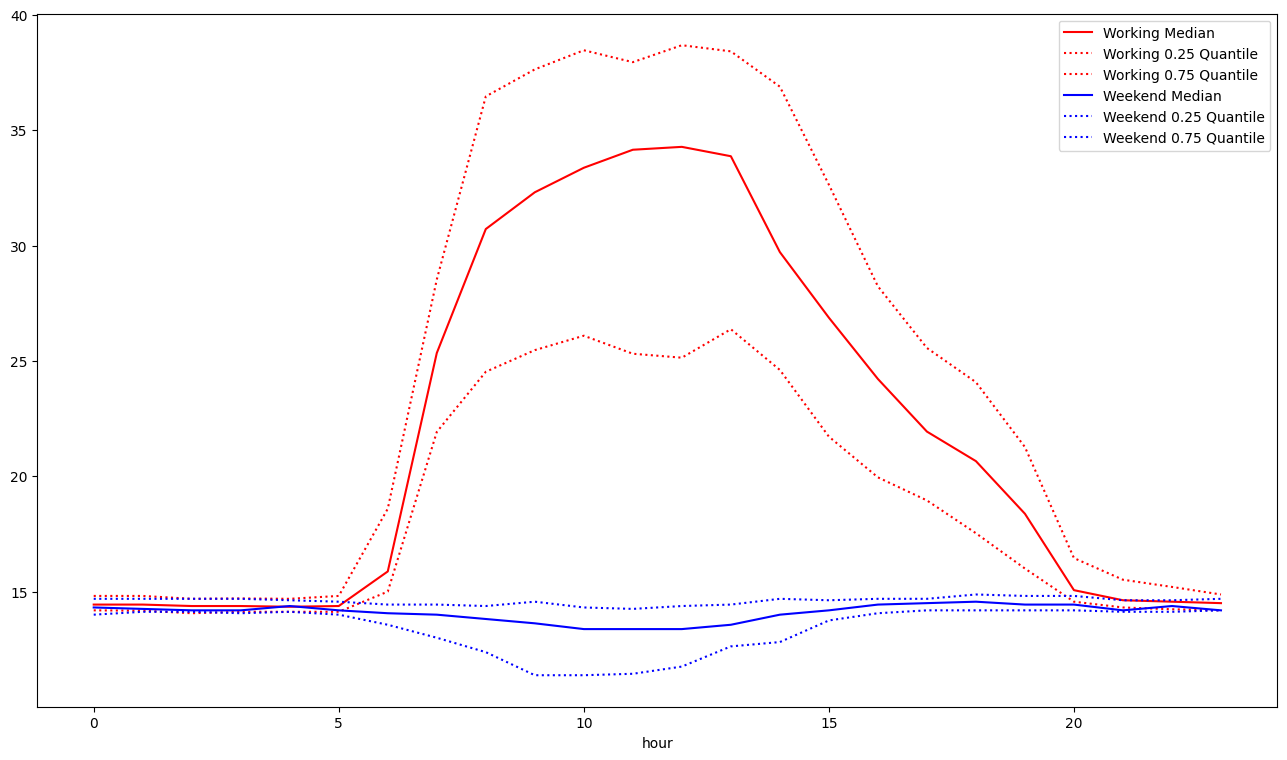

In [11]:
#
# Plot the median of all weekdays
#

pivot_workingdays.median(axis=1).plot(color="red", label="Working Median")
pivot_workingdays.quantile(0.25,axis=1).plot(color="red",linestyle='dotted', label="Working 0.25 Quantile")
pivot_workingdays.quantile(0.75,axis=1).plot(color="red",linestyle='dotted', label="Working 0.75 Quantile")
pivot_weekends.median(axis=1).plot(color="blue", label="Weekend Median")
pivot_weekends.quantile(0.25,axis=1).plot(color="blue",linestyle='dotted', label="Weekend 0.25 Quantile")
pivot_weekends.quantile(0.75,axis=1).plot(color="blue",linestyle='dotted', label="Weekend 0.75 Quantile")
plt.legend()

 ### <span style="color:#A00000 "> Discuss in your group:</span>
 - <span style="color:#A00000 "> Do these different plots (weekdays, weekends, median) fit your expectations?</span>
 - <span style="color:#A00000 "> What could explain the pattern for this building for a weekday? </span>
 - <span style="color:#A00000 "> Could you interfer the base load of the building by looking at the daily observation plots? </span>
 - <span style="color:#A00000 "> How could explain the higher variance of weekdays in contrast to weekends? </span>
 - <span style="color:#A00000 "> Based on these observations, what features would you consider extracting or engineering for a forecasting task? </span>

< Space for your answers>


## Autorcorrelation Function and Seasonal Decomposition

### Autocorrelation Function Plot


The autocorrelation function (ACF) is a statistical technique that we can use to identify how correlated the values in a time series are with each other. The ACF plots the correlation coefficient against the lag, which is measured in terms of a number of periods or units. [Explanation from here](https://www.baeldung.com/cs/acf-pacf-plots-arma-modeling#:~:text=The%20autocorrelation%20function%20(ACF)%20is,number%20of%20periods%20or%20units.)

An detailed expleanation is here: [Autocorrelation](https://support.minitab.com/en-us/minitab/21/help-and-how-to/statistical-modeling/time-series/how-to/autocorrelation/interpret-the-results/autocorrelation-function-acf/)

API-Statsmodels [API](https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.acf.html)

### Seasonal Decomposition

An detailed explaination about the used seasonal decomposition can be found here: [API](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)

The additive model which is used here is defined as $Y[t] = T[t] + S[t] + e[t]$.

The results are obtained by first estimating the trend by applying a convolugit stion filter to the data. The trend is then removed from the series and the average of this de-trended series for each period is the returned seasonal component.

#### Demand ACF and Seasonal Decomposition

 ### <span style="color:#A00000 "> Play around with autocorrelation: </span>
- <span style="color:#A00000 "> Use the ``sm.tsa.graphics.plot_acf(x, lags=None)`` function to plot the autocorrelation function of ``data["demand"]``. </span>
- <span style="color:#A00000 "> Play around with a different number of lags, i.e. 5, 24, 200. </span>
- <span style="color:#A00000 "> What do you observe? </span>

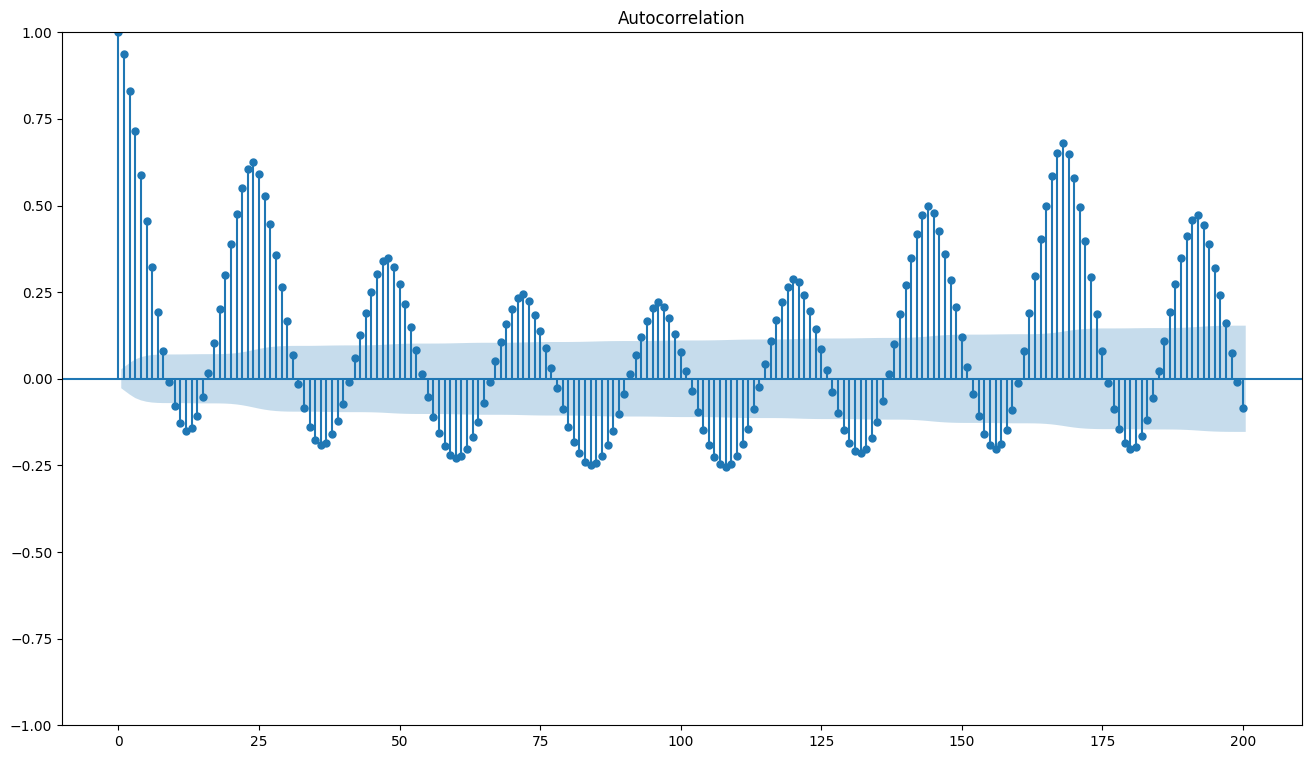

In [12]:
sm.tsa.graphics.plot_acf(data["demand"], lags= 200);

 ### <span style="color:#A00000 "> Play around with seasonal decomposition: </span>
- <span style="color:#A00000 "> Use the ``statsmodels.tsa.seasonal.seasonal_decompose(x, period=None)`` function to create a seasonal decomposition of ``data["demand"]``. </span>
- <span style="color:#A00000 "> Visualise this decomposition with ``sm.tsa.seasonal_decompose().plot()``. </span>
- <span style="color:#A00000 "> Adjust the ''period'' parameter of the function, try for example 24 (a day), or 168 (a week), or something random (e.g. 77). </span>
- <span style="color:#A00000 "> What do you observe? </span>

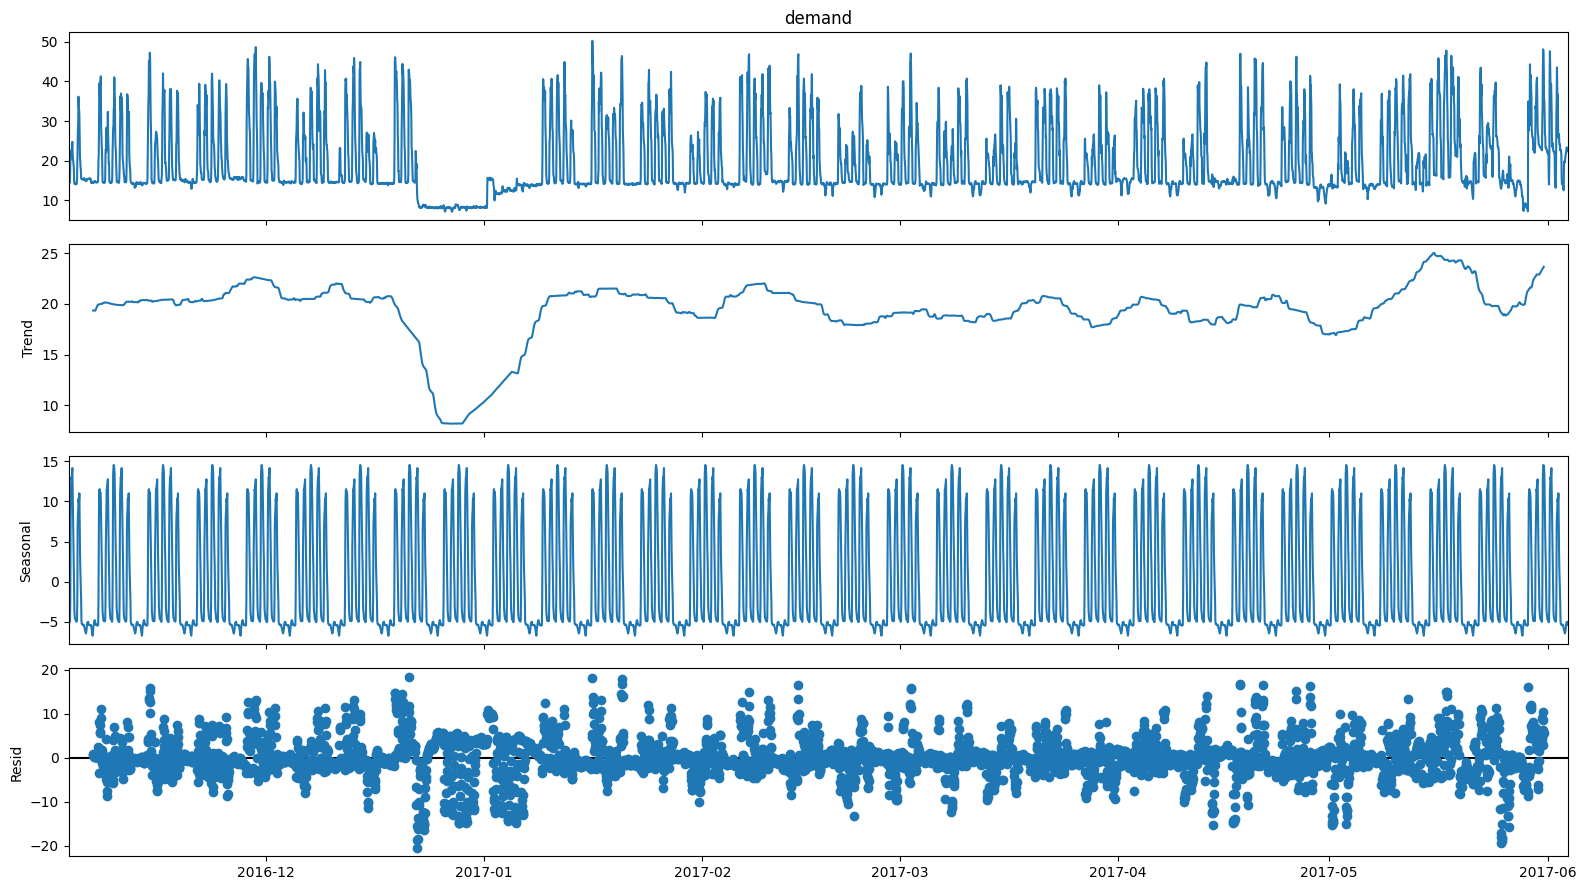

In [13]:
# do seasonal decomposition of demand here
# this get's gapped
sm.tsa.seasonal_decompose(data["demand"], period=24 * 7 ).plot();


### ACF and Seasonal Decomposition Solar

 ### <span style="color:#A00000 "> Repeat the above two tasks for the solar data! </span>

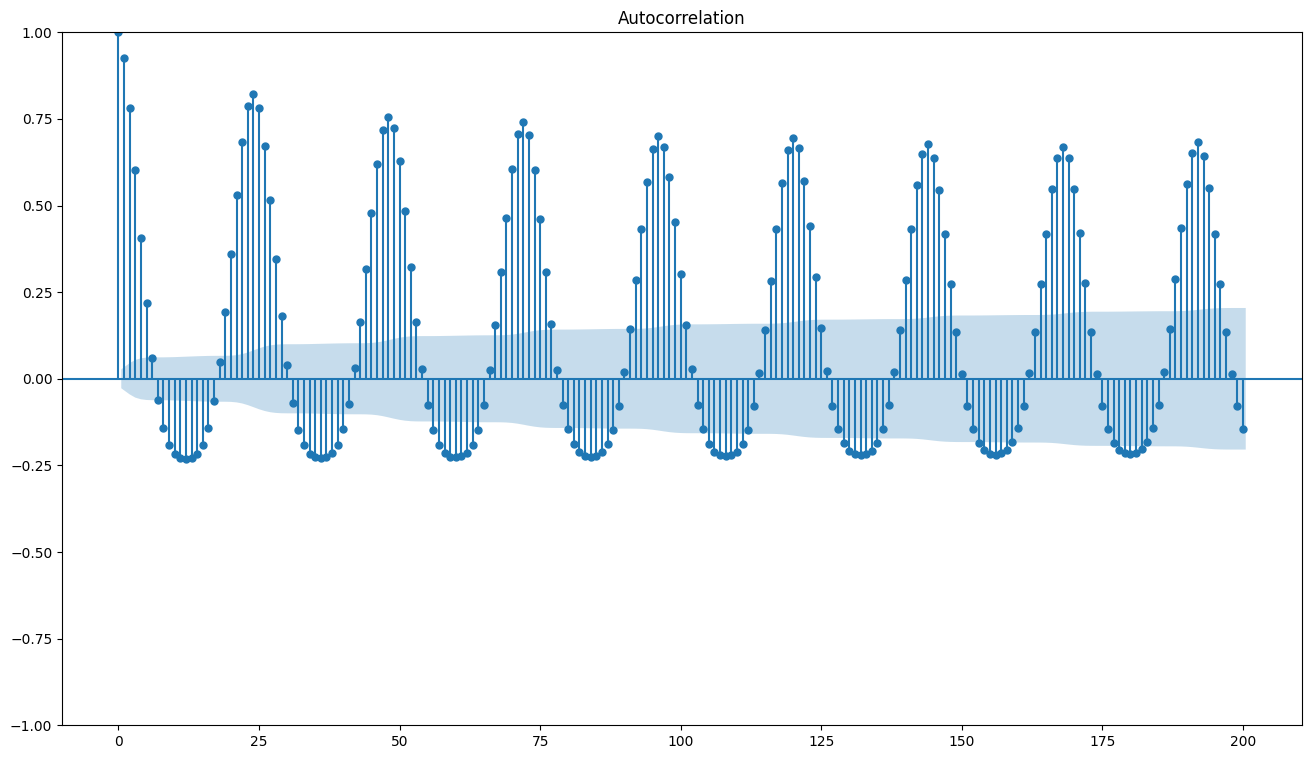

In [14]:
# do seasonale decomposition on solar data (data["solar"])
# Gap here for acf
sm.tsa.graphics.plot_acf(data["solar"], lags= 200);

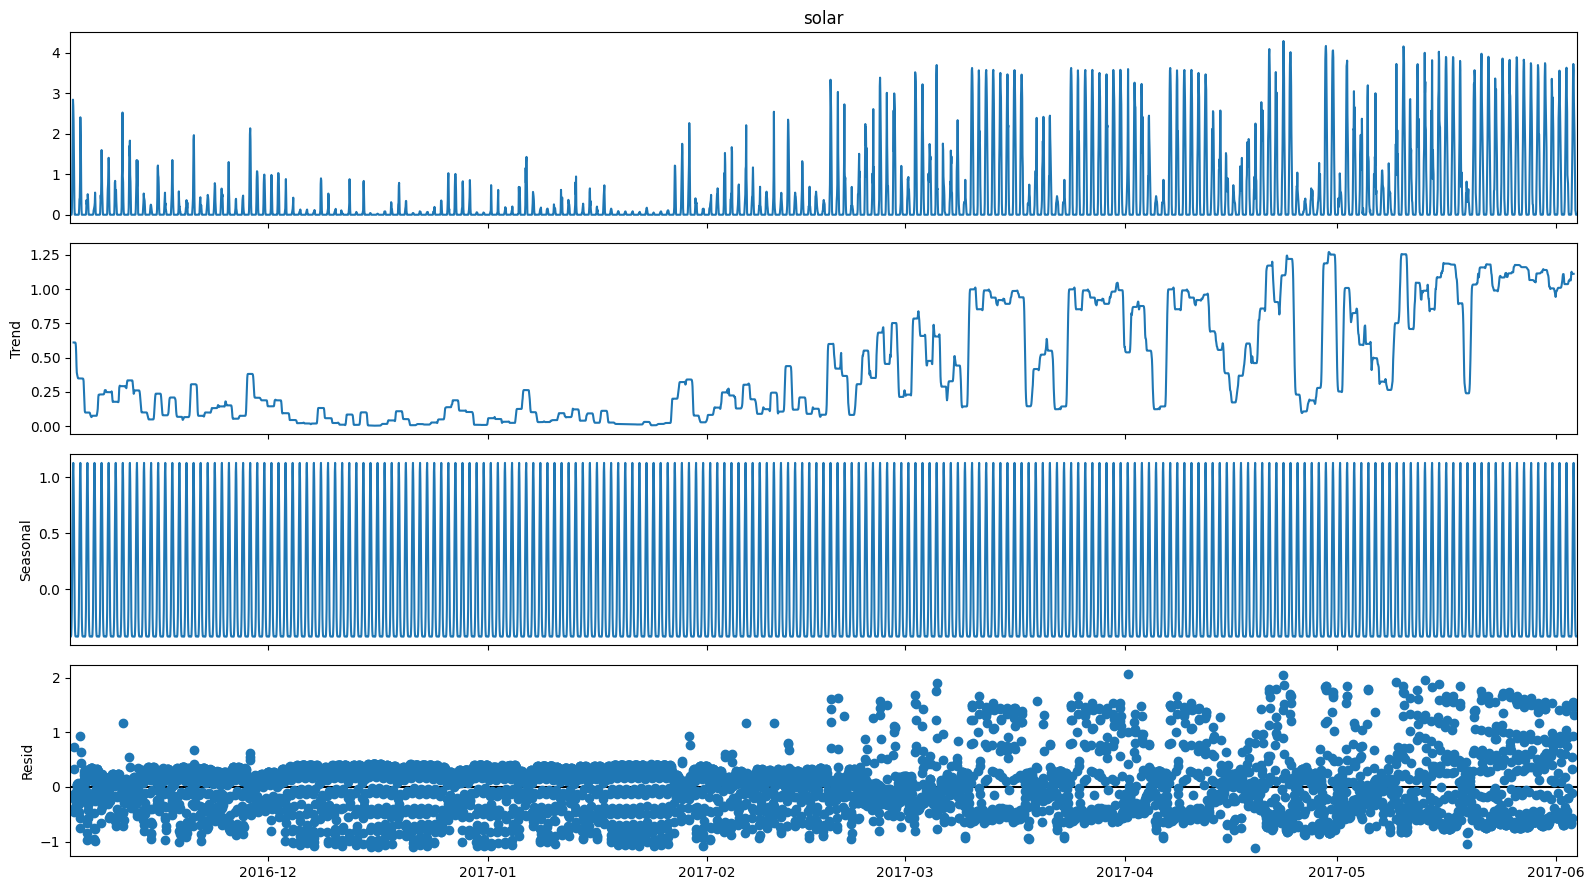

In [15]:
# do seasonal decomposition of demand here
# this get's gapped
sm.tsa.seasonal_decompose(data["solar"], period=24).plot();


# <span style="color:#A00000 ">  STOP HERE - We want to discuss some things together before going on </span>

# **3. Forecasting Excercise - Forecasting Pipeline and Steps**

In this section of the Jupyter Notebook, you will learn about using SkTime to perform time series forecasting. Time series forecasting is a technique used to predict future values of a variable based on historical data and possible known exogenous variables. It can be useful in many fields, such as finance, economics, and engineering, but also in energy informatics.



## Exercises

The exercises walk you through the creation of a time series forecast. You will see a very basic sktime workflow producing a time series forecast of the data already known from the previous excercise.

Now, let's look at what we prepared:

### Data
We use the data from the previous excercise part.

### Metrics

To evaluate the accuracy of the forecast, the section provides various metrics, such as mean absolute error and root mean squared error. These metrics allow you to understand how close the forecasted values are to the actual values. Those metrics are introduced here:


$ \text{MAPE} = \frac{1}{n} \sum_{t=1}^{n} \left| \frac{A_t - F_t}{A_t} \right| $

$ \text{MAE} = \frac{1}{n} \sum_{t=1}^{n} \left| A_t - F_t \right| $

$ \text{MSE} = \frac{1}{n} \sum_{t=1}^{n} \left( A_t - F_t \right)^2 $




- <span style="color:#A00000 "> What are those Metrics sensitive for?</span>



### Models


###
To help with the interpretation of the results, the section includes visualizations of the forecasted values and actual values over time. These visualizations can help you identify trends and patterns that may not be immediately apparent from the metrics alone.

Overall, this section provides a practical introduction to using sktime for time series forecasting. By the end of the section you have understood a basic example for time series forecasting. 

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='demand'>)

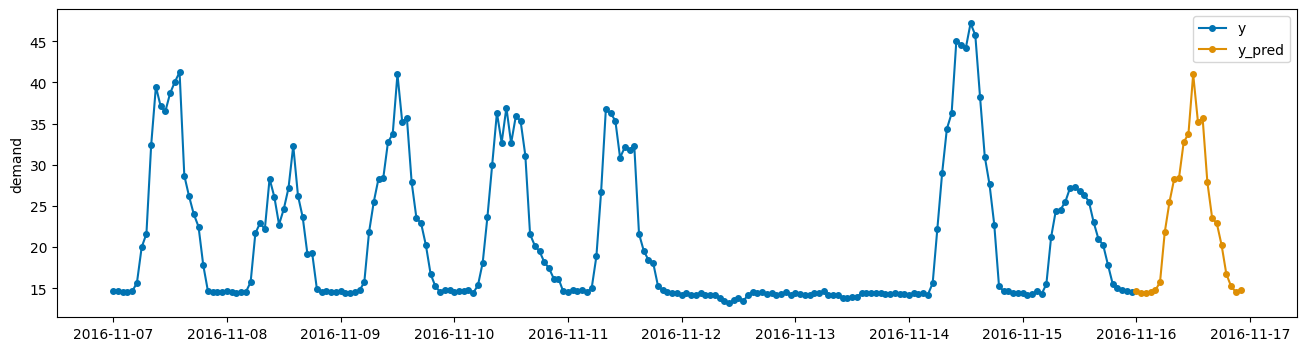

In [16]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_evaluation import evaluate
from sktime.split import ExpandingWindowSplitter
from sktime.forecasting.compose import make_reduction
from sklearn.neighbors import KNeighborsRegressor
from sktime.performance_metrics.forecasting import MeanAbsoluteError , MeanSquaredError , MedianAbsolutePercentageError
import warnings

#
# Needed as sktime throws a lot of exceptions
#

warnings.filterwarnings("ignore")


#
# Dummy Demonstration How the basic sktime workflow for prediction works within a naive forecaster 
#

# step 1: data specification
y = data["demand"][24*4:24*13]
# step 2: specifying forecasting horizon
fh = np.arange(1, 24)
# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=24*7)
# step 4: fitting the forecaster
forecaster.fit(y)
# step 5: querying predictions
y_pred = forecaster.predict(fh)
# optional: plotting predictions and past data
plot_series(y, y_pred, labels=["y", "y_pred"])


### <span style="color:#A00000 "> Discuss with your group: </span>
- <span style="color:#A00000 "> Discuss what the naiv forecaster does? </span>
- <span style="color:#A00000 "> Why could a navie forecaster could be useful?</span>
- <span style="color:#A00000 "> What is the basic assumption behind a naive forecaster?</span>
- <span style="color:#A00000 "> Where a naive forecaster fails and why?</span>
- <span style="color:#A00000 "> How can other forecaster prevent this?</span>

In [37]:
cv = ExpandingWindowSplitter(
    step_length=24, fh=[i for i in range(1,25)], initial_window=100*24
)

metrics = [MedianAbsolutePercentageError(), MeanAbsoluteError(), MeanSquaredError()]

y = data["demand"]


#
#   NaiveForecaster
#

forecaster = NaiveForecaster(strategy="last", sp=24*7)
df_naive = evaluate(forecaster=forecaster, y=y, cv=cv, return_data=True,scoring=metrics)


#
#   KNeighborsRegressor
#  

regressor = KNeighborsRegressor(n_neighbors=3)
forecaster = make_reduction(regressor, window_length=24*7, strategy="direct")
df_knr = evaluate(forecaster=forecaster, y=y, cv=cv,return_data=True, strategy="refit",scoring=metrics)




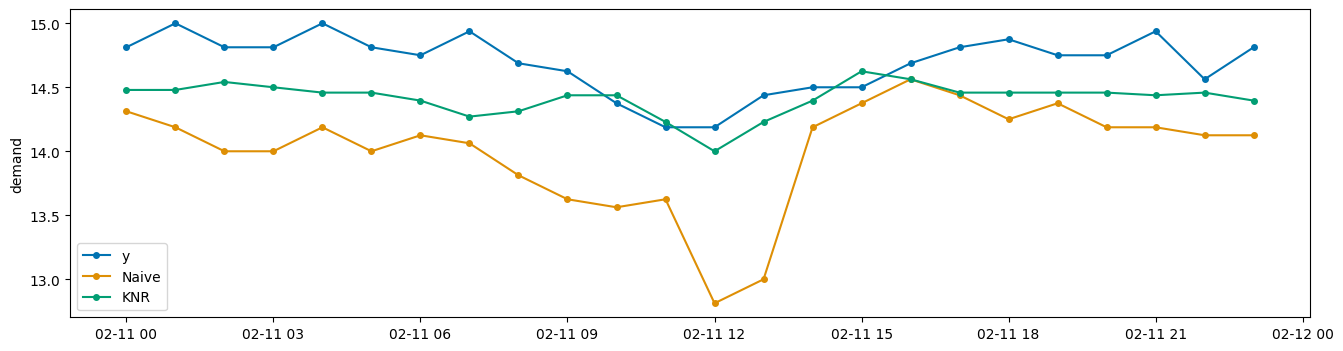

In [38]:
# visualization of a forecaster evaluation

day = 1

fig, ax = plot_series(
    y.iloc[24*100+(24*(day-1)):24*100+24*day],
    df_naive["y_pred"].iloc[day-1],
    df_knr["y_pred"].iloc[day-1],
    labels=["y", "Naive", "KNR"],
)

In [39]:
# Evaluation Block using the different metrics

loss_cols = ["test_MedianAbsolutePercentageError","test_MeanAbsoluteError","test_MeanSquaredError"]

# generate a dataframe containing the results

df_results = pd.DataFrame(columns=["Model","MAPE","MAE","MSE"])

# add all forecasters in a list with thier results

df_results_naiv = pd.DataFrame({"Model":"Naive","MAPE":df_naive["test_MedianAbsolutePercentageError"].mean(),"MAE":df_naive["test_MeanAbsoluteError"].mean(),"MSE":df_naive["test_MeanSquaredError"].mean()},index=[0])
df_results_knr = pd.DataFrame({"Model":"KNR","MAPE":df_knr["test_MedianAbsolutePercentageError"].mean(),"MAE":df_knr["test_MeanAbsoluteError"].mean(),"MSE":df_knr["test_MeanSquaredError"].mean()},index=[0])

df_results = pd.concat([df_results,df_results_naiv,df_results_knr])

df_results


,Model,MAPE,MAE,MSE
0,Naive,0.115169,3.712618,40.857742
0,KNR,0.110624,3.262621,30.763773


# Enrich the forecast with features

In [40]:

from sktime.transformations.series.date import DateTimeFeatures
from sktime.transformations.series.holiday import HolidayFeatures
from holidays import country_holidays

holiday_transformer = HolidayFeatures(
   calendar=country_holidays(country="DE",state="BW"),
   include_bridge_days=True
   )  
X_holiday = holiday_transformer.fit_transform(y)
X_holiday["holiday"] = X_holiday.sum(axis=1)



calendar_transformer = DateTimeFeatures(ts_freq="H", manual_selection=["day_of_week", "hour_of_day"])
X_calendar = calendar_transformer.fit_transform(y)

#join them together as a feature matrix

X = pd.concat([X_holiday["holiday"], X_calendar], axis=1)



In [41]:
#
#   KNeighborsRegressor
#  

regressor = KNeighborsRegressor(n_neighbors=3)
forecaster = make_reduction(regressor, window_length=24*7, strategy="direct")
df_knr_features = evaluate(forecaster=forecaster,y=y,X=X,cv=cv,return_data=True, strategy="refit",scoring=metrics)



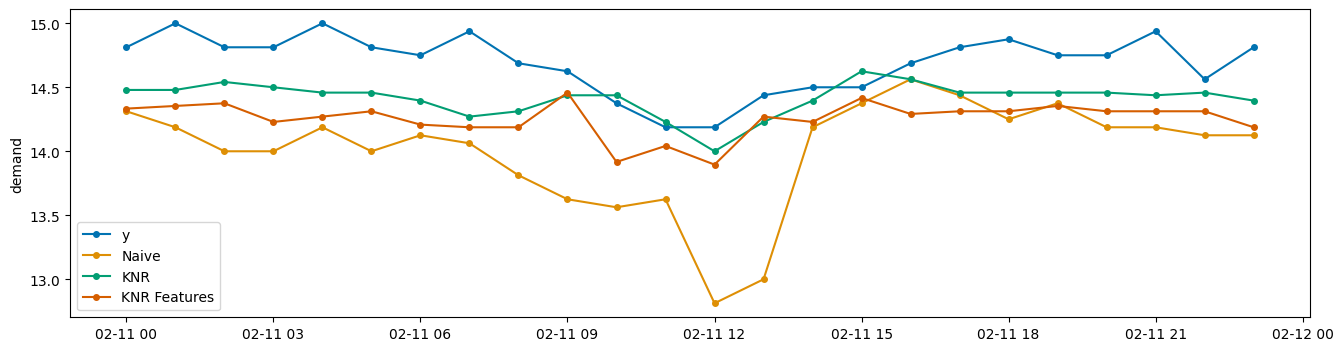

In [42]:
# visualization of a forecaster evaluation

day = 1

fig, ax = plot_series(
    y.iloc[24*100+(24*(day-1)):24*100+24*day],
    df_naive["y_pred"].iloc[day-1],
    df_knr["y_pred"].iloc[day-1],
    df_knr_features["y_pred"].iloc[day-1],
    labels=["y", "Naive", "KNR", "KNR Features"],
)

In [43]:
# Evaluation Block using the different metrics

loss_cols = ["test_MedianAbsolutePercentageError","test_MeanAbsoluteError","test_MeanSquaredError"]

# generate a dataframe containing the results

df_results = pd.DataFrame(columns=["Model","MAPE","MAE","MSE"])

# add all forecasters in a list with thier results

df_results_naiv = pd.DataFrame({"Model":"Naive","MAPE":df_naive["test_MedianAbsolutePercentageError"].mean(),"MAE":df_naive["test_MeanAbsoluteError"].mean(),"MSE":df_naive["test_MeanSquaredError"].mean()},index=[0])
df_results_knr = pd.DataFrame({"Model":"KNR","MAPE":df_knr["test_MedianAbsolutePercentageError"].mean(),"MAE":df_knr["test_MeanAbsoluteError"].mean(),"MSE":df_knr["test_MeanSquaredError"].mean()},index=[0])
df_results_knr_features = pd.DataFrame({"Model":"KNR Features","MAPE":df_knr_features["test_MedianAbsolutePercentageError"].mean(),"MAE":df_knr_features["test_MeanAbsoluteError"].mean(),"MSE":df_knr_features["test_MeanSquaredError"].mean()},index=[0])

df_results = pd.concat([df_results,df_results_naiv,df_results_knr,df_results_knr_features])

df_results




,Model,MAPE,MAE,MSE
0,Naive,0.115169,3.712618,40.857742
0,KNR,0.110624,3.262621,30.763773
0,KNR Features,0.107153,3.147700,27.172455


Now we are going to visualise the data...

## <span style="color:#A00000 "> Now you can play! </span>
- <span style="color:#A00000 "> Play around with the forecast horizon and the number of historical features.</span>
- <span style="color:#A00000 "> You can also try altering the scope variable being forecast.</span>
- <span style="color:#A00000 "> How do the results change?</span>
- <span style="color:#A00000 "> Which forecasters perform best?</span>
- <span style="color:#A00000 "> How quantity is the easiest to forecast?</span>
<span style="color:#A00000 ">Feel free to spend time discussing the results in your group and if you have questions don't hesitate to ask!</span>

<img src="https://imgs.xkcd.com/comics/machine_learning.png" width="600" height="800">

[This xkcd comic you can find here](https://xkcd.com/1838/)